In [1]:
#import modules
import SimpleITK as sitk

from platipy.imaging.visualisation.tools import ImageVisualiser
from platipy.imaging.utils.tools import get_com
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

<IPython.core.display.Javascript object>


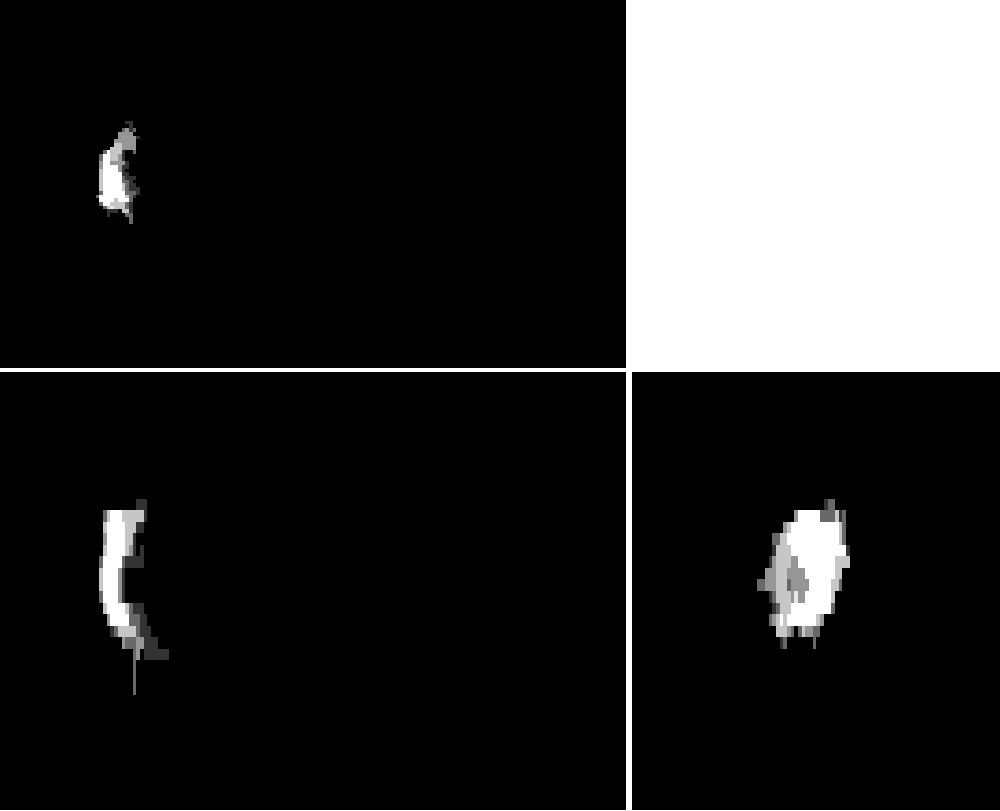

In [4]:
#add segs tp4
seg_B50T=sitk.ReadImage("test_label_threshold_010_4_B50T_hist.nii.gz")
seg_B800T=sitk.ReadImage("test_label_threshold_010_4_B800T_hist.nii.gz")
seg_T2=sitk.ReadImage("test_label_threshold_010_4_T2w_hist.nii.gz")
seg_MPE=sitk.ReadImage("test_label_threshold_010_4_MPE_hist.nii.gz")

seg_B50T=sitk.Resample(seg_B50T,seg_T2)
seg_B800T=sitk.Resample(seg_B800T,seg_T2)
seg_MPE=sitk.Resample(seg_MPE,seg_T2)

new_seg_T2=sitk.LabelMapToBinary(sitk.Cast(seg_T2, sitk.sitkLabelUInt8))
new_seg_B50T=sitk.LabelMapToBinary(sitk.Cast(seg_B50T, sitk.sitkLabelUInt8))
new_seg_B800T=sitk.LabelMapToBinary(sitk.Cast(seg_B800T, sitk.sitkLabelUInt8))
new_seg_MPE=sitk.LabelMapToBinary(sitk.Cast(seg_MPE, sitk.sitkLabelUInt8))

new_TRACE_seg=(new_seg_B50T+new_seg_B800T)/2#sitk.Cast((new_seg_B50T+new_seg_B800T)/2,sitk.sitkUInt8)
new_seg_1=(sitk.Cast(new_seg_T2,sitk.sitkFloat64)+new_TRACE_seg+sitk.Cast(new_seg_MPE,sitk.sitkFloat64)) #need to threshold this somehow
vis=ImageVisualiser(new_seg_1, cut=get_com(new_seg_1), window=[0,3])
fig=vis.show()

<IPython.core.display.Javascript object>


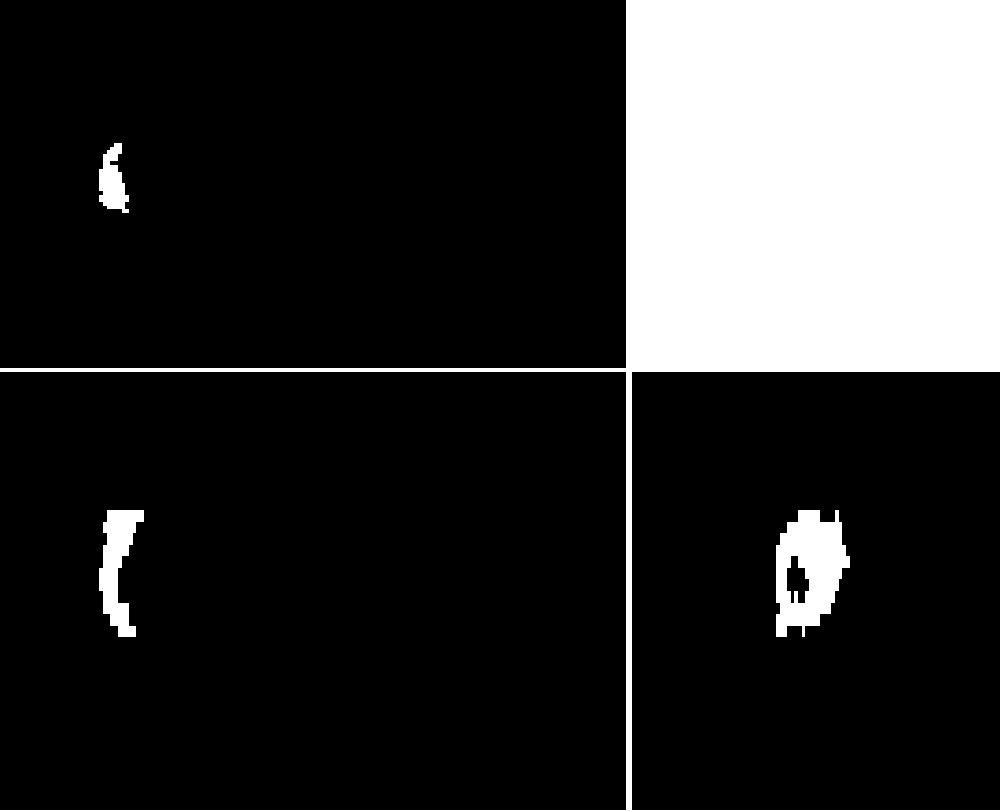

In [5]:
new_seg_1_1=sitk.BinaryThreshold(new_seg_1, lowerThreshold=2)

vis=ImageVisualiser(new_seg_1_1, cut=get_com(new_seg_1), window=[0,1])
fig=vis.show()

In [6]:
sitk.WriteImage(new_seg_1_1,"new_seg_010_4_mri.nii.gz")

In [7]:
R_breast=sitk.ReadImage("/home/alicja/Downloads/Segmentation.nii.gz")

In [8]:
WES_010_4_B50T=sitk.ReadImage("/home/alicja/Documents/WES_010/IMAGES/WES_010_4_20180829_MR_EP2D_DIFF_TRA_SPAIR_ZOOMIT_EZ_B50T_EP2D_DIFF_TRA_SPAIR_ZOOMIT_TRACEW_DFC_MIX_5.nii.gz")
WES_010_4_B800T=sitk.ReadImage("/home/alicja/Documents/WES_010/IMAGES/WES_010_4_20180829_MR_EP2D_DIFF_TRA_SPAIR_ZOOMIT_EZ_B800T_EP2D_DIFF_TRA_SPAIR_ZOOMIT_TRACEW_DFC_MIX_5.nii.gz")

In [9]:
from platipy.imaging.visualisation.tools import ImageVisualiser

from platipy.imaging.registration.registration import (
    initial_registration,
    fast_symmetric_forces_demons_registration,
    transform_propagation,
    apply_field
)

In [10]:
#DIR to tp5
WES_010_5_B50T=sitk.ReadImage("/home/alicja/Documents/WES_010/IMAGES/WES_010_5_20181010_MR_EP2D_DIFF_TRA_SPAIR_ZOOMIT_EZ_B50T_EP2D_DIFF_TRA_SPAIR_ZOOMIT_TRACEW_DFC_MIX_6.nii.gz")
image_to_0_rigid, tfm_to_0_rigid = initial_registration(
    WES_010_5_B50T,
    WES_010_4_B50T,
    options={
        'shrink_factors': [8,4],
        'smooth_sigmas': [0,0],
        'sampling_rate': 0.5,
        'final_interp': 2,
        'metric': 'mean_squares',
        'optimiser': 'gradient_descent_line_search',
        'number_of_iterations': 25},
    reg_method='Rigid')

image_to_0_dir, tfm_to_0_dir = fast_symmetric_forces_demons_registration(
    WES_010_5_B50T,
    image_to_0_rigid,
    resolution_staging=[4,2],
    iteration_staging=[10,10]
)

R_breast_to_0_rigid = transform_propagation(
    WES_010_5_B50T,
    R_breast,
    tfm_to_0_rigid,
    structure=True
)

R_breast_to_0_dir = apply_field(
    R_breast_to_0_rigid,
    tfm_to_0_dir,
    structure=True
)

You have selected a single axis and multiple slice locations, attempting to match.


<IPython.core.display.Javascript object>


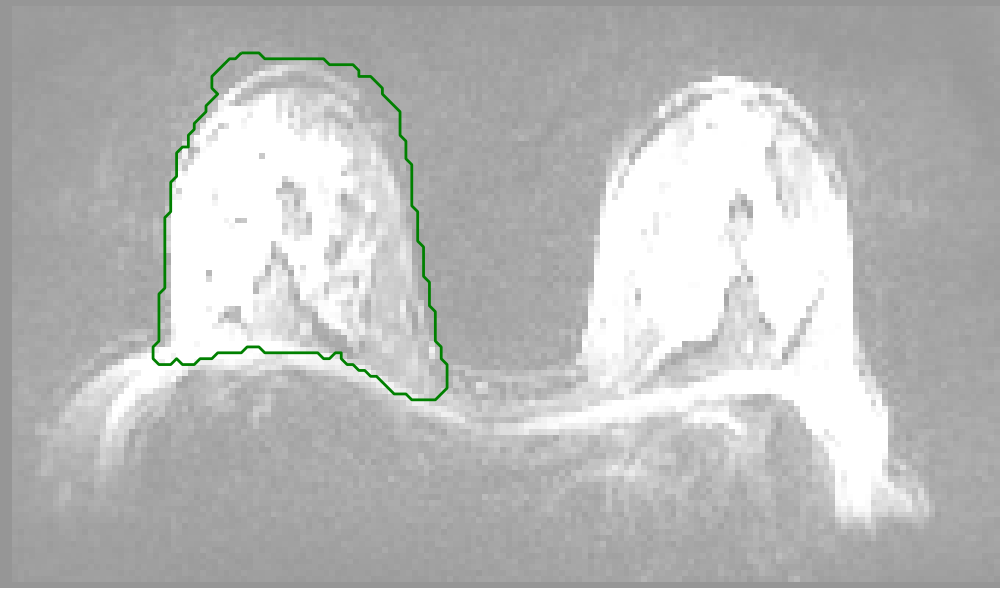

No contour levels were found within the data range.
The following kwargs were not used by contour: 'label'


In [11]:
vis = ImageVisualiser(WES_010_5_B50T, axis='z', cut=get_com(R_breast_to_0_dir), window=[-250, 500])
vis.add_contour(R_breast_to_0_dir, name='BREAST', color='g')
fig = vis.show()

In [12]:
breast_contour_dilate=sitk.BinaryDilate(R_breast_to_0_dir, (2,2,2))

<IPython.core.display.Javascript object>


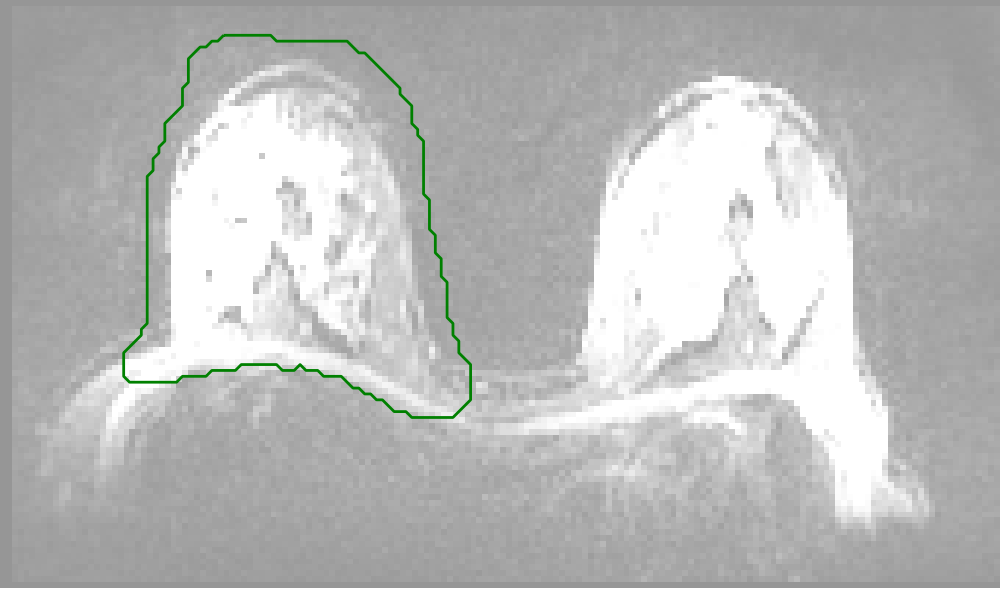

In [14]:
vis = ImageVisualiser(WES_010_5_B50T, axis='z', cut=get_com(R_breast_to_0_dir), window=[-250, 500])
vis.add_contour(breast_contour_dilate, name='BREAST', color='g')
fig = vis.show()

In [15]:
masked_R_breast = sitk.Mask(WES_010_5_B50T, breast_contour_dilate)

<IPython.core.display.Javascript object>


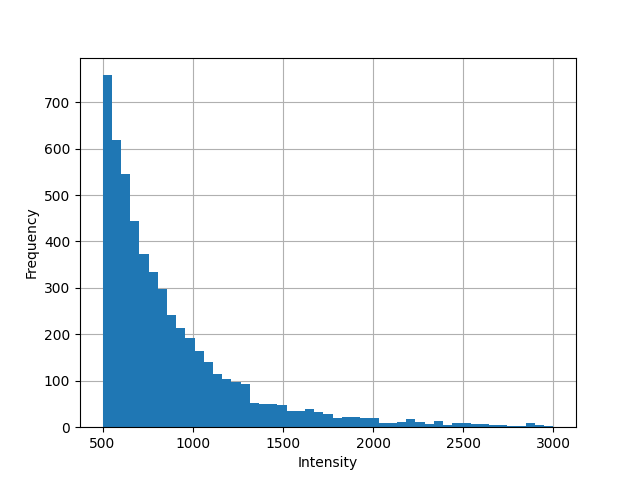

In [20]:
values = sitk.GetArrayViewFromImage(masked_R_breast).flatten()

fig, ax = plt.subplots(1,1)
ax.hist(values, bins=np.linspace(500,3000,50), histtype='stepfilled', lw=2)
#ax.set_yscale('log')
ax.grid()
ax.set_axisbelow(True)
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
fig.show()

In [22]:
image_mri=WES_010_5_B50T
arr_mri = sitk.GetArrayFromImage(image_mri)
arr_mri[:,:,arr_mri.shape[2]//2:] = 0
image_mri_masked=sitk.GetImageFromArray(arr_mri)
image_mri_masked.CopyInformation(image_mri)

label_threshold_cc_x_f=estimate_tumour_vol(image_mri_masked, lowerthreshold=950, upperthreshold=5000, hole_size=1)

sitk.WriteImage(label_threshold_cc_x_f,"test_label_threshold_010_5_B50T_hist.nii.gz")

In [18]:
def estimate_tumour_vol(img_mri, lowerthreshold=300, upperthreshold=3000, hole_size=1):
    label_threshold = sitk.BinaryThreshold(img_mri, lowerThreshold=lowerthreshold, upperThreshold=upperthreshold)
    label_threshold_cc = sitk.RelabelComponent(sitk.ConnectedComponent(label_threshold))
    label_threshold_cc_x = (label_threshold_cc==1)
    label_threshold_cc_x_f = sitk.BinaryMorphologicalClosing(label_threshold_cc_x, (hole_size,hole_size,hole_size))
    return(label_threshold_cc_x_f)

In [23]:
WES_010_5_B800T=sitk.ReadImage("/home/alicja/Documents/WES_010/IMAGES/WES_010_5_20181010_MR_EP2D_DIFF_TRA_SPAIR_ZOOMIT_EZ_B800T_EP2D_DIFF_TRA_SPAIR_ZOOMIT_TRACEW_DFC_MIX_6.nii.gz")
WES_010_5_T2w=sitk.ReadImage("/home/alicja/Documents/WES_010/IMAGES/WES_010_5_20181010_MR_T2_TSE_TRA_SPAIR_TSE2D1_11_T2_TSE_TRA_SPAIR_3.nii.gz")
WES_010_5_MPE=sitk.ReadImage("MPE_sub_WES_010_5.nii.gz")

masked_R_breast = sitk.Mask(WES_010_5_B800T, breast_contour_dilate)

<IPython.core.display.Javascript object>


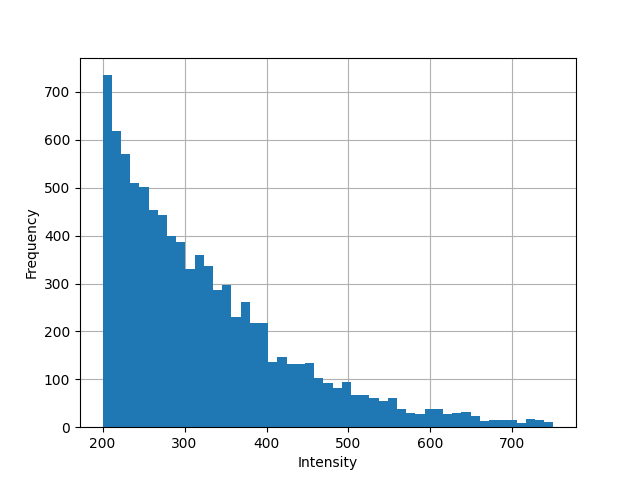

In [31]:
values = sitk.GetArrayViewFromImage(masked_R_breast).flatten()

fig, ax = plt.subplots(1,1)
ax.hist(values, bins=np.linspace(200,750,50), histtype='stepfilled', lw=2)
#ax.set_yscale('log')
ax.grid()
ax.set_axisbelow(True)
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
fig.show()

In [33]:
image_mri=WES_010_5_B800T
arr_mri = sitk.GetArrayFromImage(image_mri)
arr_mri[:,:,arr_mri.shape[2]//2:] = 0
image_mri_masked=sitk.GetImageFromArray(arr_mri)
image_mri_masked.CopyInformation(image_mri)

label_threshold_cc_x_f=estimate_tumour_vol(image_mri_masked, lowerthreshold=400, upperthreshold=5000, hole_size=1)

sitk.WriteImage(label_threshold_cc_x_f,"test_label_threshold_010_5_B800T_hist.nii.gz") #ok but picks up fibro

<IPython.core.display.Javascript object>


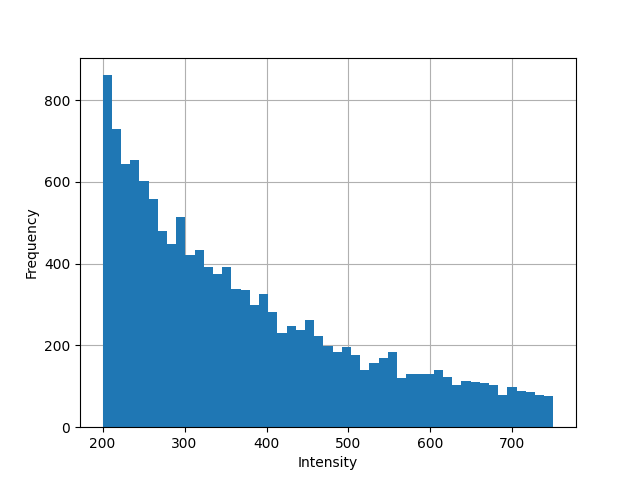

In [49]:
WES_010_5_T2w=sitk.Resample(WES_010_5_B50T)
masked_R_breast = sitk.Mask(WES_010_5_T2w, breast_contour_dilate)
values = sitk.GetArrayViewFromImage(masked_R_breast).flatten()

fig, ax = plt.subplots(1,1)
ax.hist(values, bins=np.linspace(200,750,50), histtype='stepfilled', lw=2)
#ax.set_yscale('log')
ax.grid()
ax.set_axisbelow(True)
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
fig.show()

In [51]:
image_mri=WES_010_5_B800T
arr_mri = sitk.GetArrayFromImage(image_mri)
arr_mri[:,:,arr_mri.shape[2]//2:] = 0
image_mri_masked=sitk.GetImageFromArray(arr_mri)
image_mri_masked.CopyInformation(image_mri)

label_threshold_cc_x_f=estimate_tumour_vol(image_mri_masked, lowerthreshold=440, upperthreshold=5000, hole_size=1)

sitk.WriteImage(label_threshold_cc_x_f,"test_label_threshold_010_5_T2w_hist.nii.gz") #picks up fibro

<IPython.core.display.Javascript object>


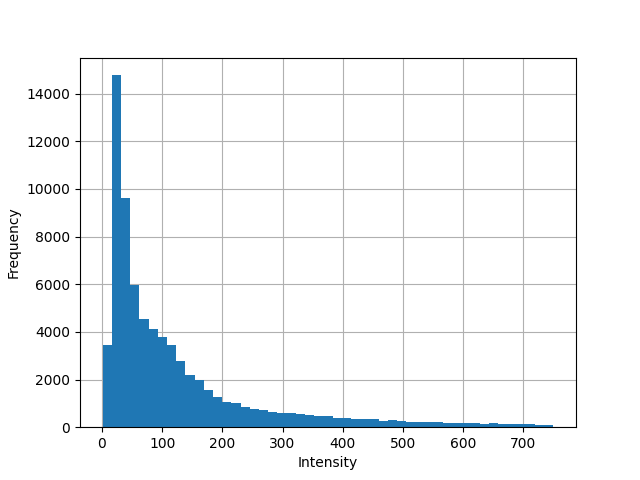

In [38]:
WES_010_5_MPE=sitk.Resample(WES_010_5_B50T)
masked_R_breast = sitk.Mask(WES_010_5_MPE, breast_contour_dilate)
values = sitk.GetArrayViewFromImage(masked_R_breast).flatten()

fig, ax = plt.subplots(1,1)
ax.hist(values, bins=np.linspace(1,750,50), histtype='stepfilled', lw=2)
#ax.set_yscale('log')
ax.grid()
ax.set_axisbelow(True)
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
fig.show()

In [42]:
image_mri=WES_010_5_MPE
arr_mri = sitk.GetArrayFromImage(image_mri)
arr_mri[:,:,arr_mri.shape[2]//2:] = 0
image_mri_masked=sitk.GetImageFromArray(arr_mri)
image_mri_masked.CopyInformation(image_mri)

label_threshold_cc_x_f=estimate_tumour_vol(image_mri_masked, lowerthreshold=640, upperthreshold=5000, hole_size=1)

sitk.WriteImage(label_threshold_cc_x_f,"test_label_threshold_010_5_MPE_hist.nii.gz") #okay but not ideal

<IPython.core.display.Javascript object>


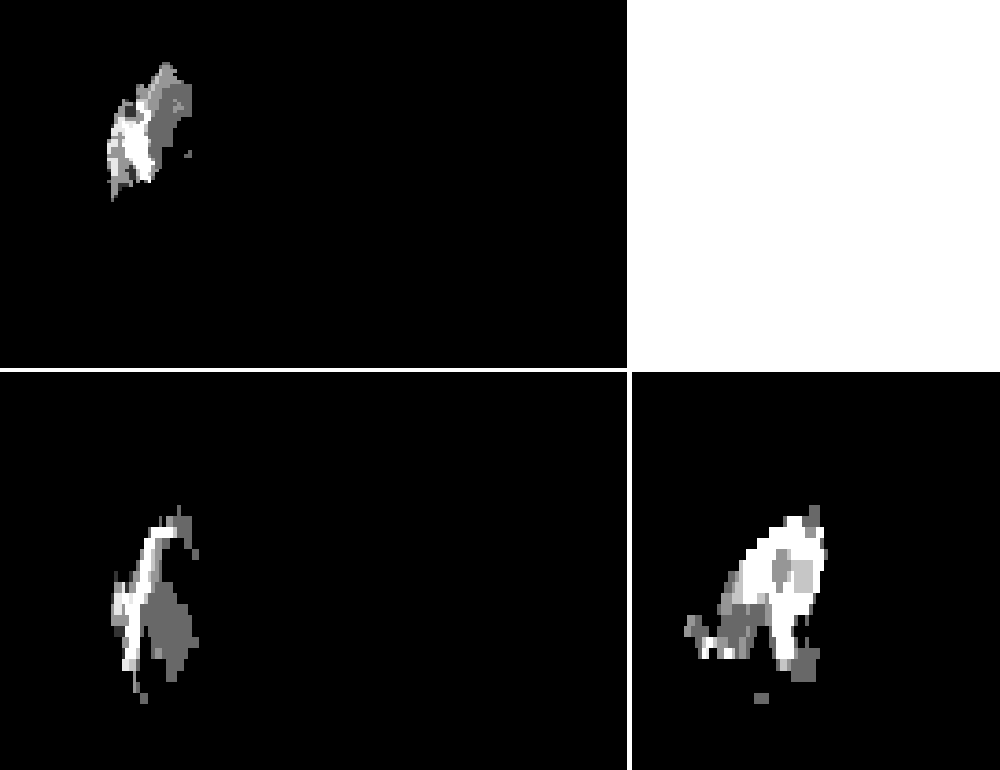

In [52]:
#add segs tp4
seg_B50T=sitk.ReadImage("test_label_threshold_010_5_B50T_hist.nii.gz")
seg_B800T=sitk.ReadImage("test_label_threshold_010_5_B800T_hist.nii.gz")
seg_T2=sitk.ReadImage("test_label_threshold_010_5_T2w_hist.nii.gz")
seg_MPE=sitk.ReadImage("test_label_threshold_010_5_MPE_hist.nii.gz")

seg_B50T=sitk.Resample(seg_B50T,seg_T2)
seg_B800T=sitk.Resample(seg_B800T,seg_T2)
seg_MPE=sitk.Resample(seg_MPE,seg_T2)

new_seg_T2=sitk.LabelMapToBinary(sitk.Cast(seg_T2, sitk.sitkLabelUInt8))
new_seg_B50T=sitk.LabelMapToBinary(sitk.Cast(seg_B50T, sitk.sitkLabelUInt8))
new_seg_B800T=sitk.LabelMapToBinary(sitk.Cast(seg_B800T, sitk.sitkLabelUInt8))
new_seg_MPE=sitk.LabelMapToBinary(sitk.Cast(seg_MPE, sitk.sitkLabelUInt8))

new_TRACE_seg=(new_seg_B50T+new_seg_B800T)/2#sitk.Cast((new_seg_B50T+new_seg_B800T)/2,sitk.sitkUInt8)
new_seg_1=(sitk.Cast(new_seg_T2,sitk.sitkFloat64)+new_TRACE_seg+sitk.Cast(new_seg_MPE,sitk.sitkFloat64)) #need to threshold this somehow
vis=ImageVisualiser(new_seg_1, cut=get_com(new_seg_1), window=[0,3])
fig=vis.show()

<IPython.core.display.Javascript object>


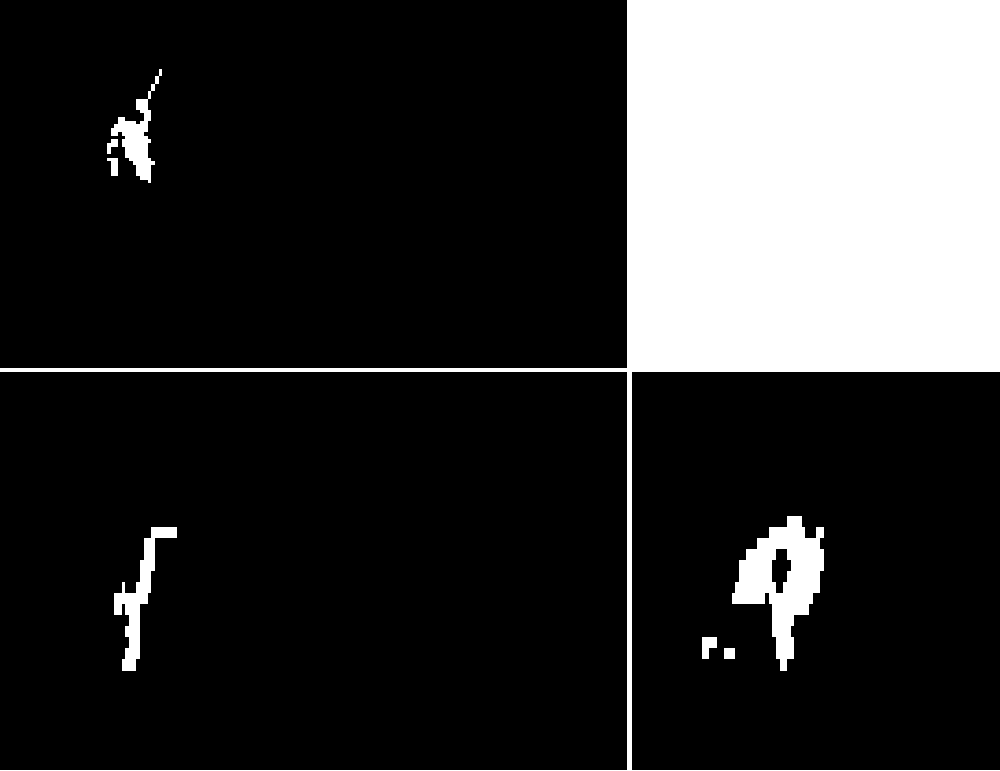

In [53]:
new_seg_1_1=sitk.BinaryThreshold(new_seg_1, lowerThreshold=2)

vis=ImageVisualiser(new_seg_1_1, cut=get_com(new_seg_1), window=[0,1])
fig=vis.show()

In [54]:
sitk.WriteImage(new_seg_1_1,"new_seg_010_5_mri.nii.gz") #not good but okay

In [62]:
#DIR to tp6
WES_010_6_B50T=sitk.ReadImage("/home/alicja/Documents/WES_010/IMAGES/WES_010_6_20190301_MR_EP2D_DIFF_TRA_SPAIR_ZOOMIT_EZ_B50T_EP2D_DIFF_TRA_SPAIR_ZOOMIT_TRACEW_DFC_5.nii.gz")
WES_010_6_B50T=sitk.Resample(WES_010_6_B50T,WES_010_5_B50T)

image_to_0_rigid, tfm_to_0_rigid = initial_registration(
    WES_010_6_B50T,
    WES_010_4_B50T,
    options={
        'shrink_factors': [8,4],
        'smooth_sigmas': [0,0],
        'sampling_rate': 0.5,
        'final_interp': 2,
        'metric': 'mean_squares',
        'optimiser': 'gradient_descent_line_search',
        'number_of_iterations': 25},
    reg_method='Rigid')

image_to_0_dir, tfm_to_0_dir = fast_symmetric_forces_demons_registration(
    WES_010_6_B50T,
    image_to_0_rigid,
    resolution_staging=[4,2],
    iteration_staging=[10,10]
)

R_breast_to_0_rigid = transform_propagation(
    WES_010_6_B50T,
    R_breast,
    tfm_to_0_rigid,
    structure=True
)

R_breast_to_0_dir = apply_field(
    R_breast_to_0_rigid,
    tfm_to_0_dir,
    structure=True
)

<IPython.core.display.Javascript object>


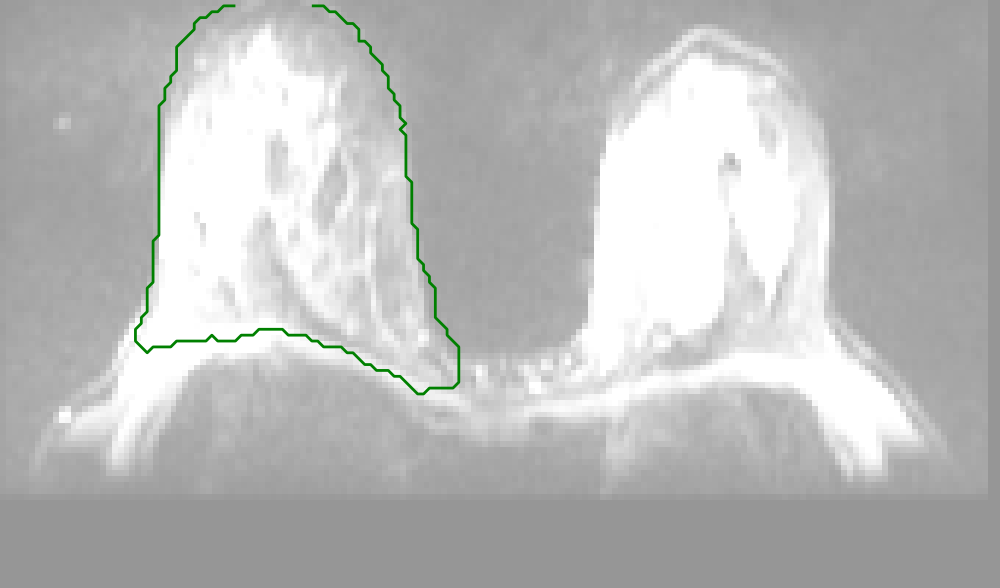

In [63]:
vis = ImageVisualiser(WES_010_6_B50T, axis='z', cut=get_com(R_breast_to_0_dir), window=[-250, 500])
vis.add_contour(R_breast_to_0_dir, name='BREAST', color='g')
fig = vis.show()

In [64]:
breast_contour_dilate=sitk.BinaryDilate(R_breast_to_0_dir, (2,2,2))

<IPython.core.display.Javascript object>


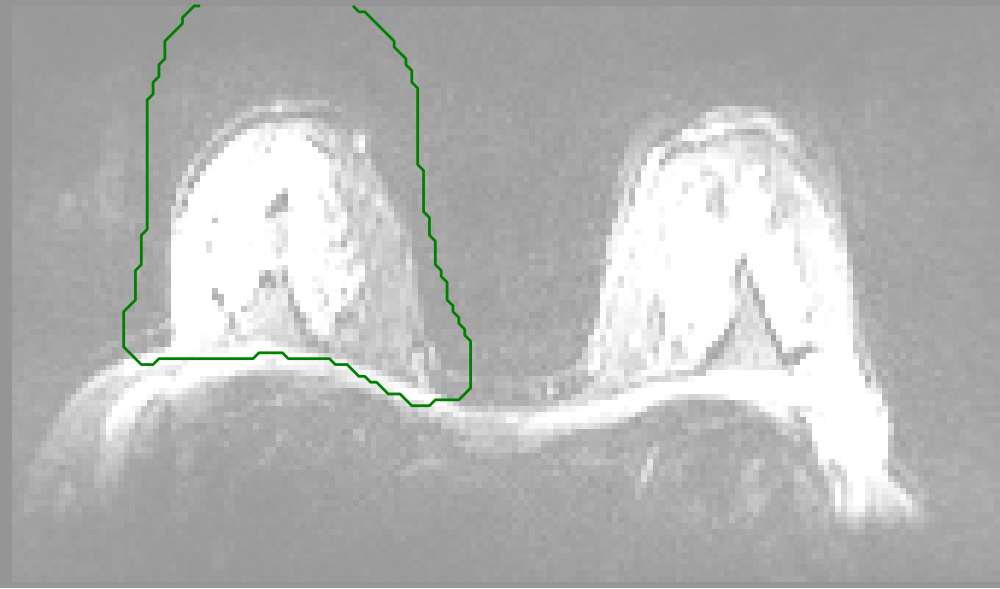

In [65]:
vis = ImageVisualiser(WES_010_5_B50T, axis='z', cut=get_com(R_breast_to_0_dir), window=[-250, 500])
vis.add_contour(breast_contour_dilate, name='BREAST', color='g')
fig = vis.show()

In [66]:
masked_R_breast = sitk.Mask(WES_010_6_B50T, breast_contour_dilate)

<IPython.core.display.Javascript object>


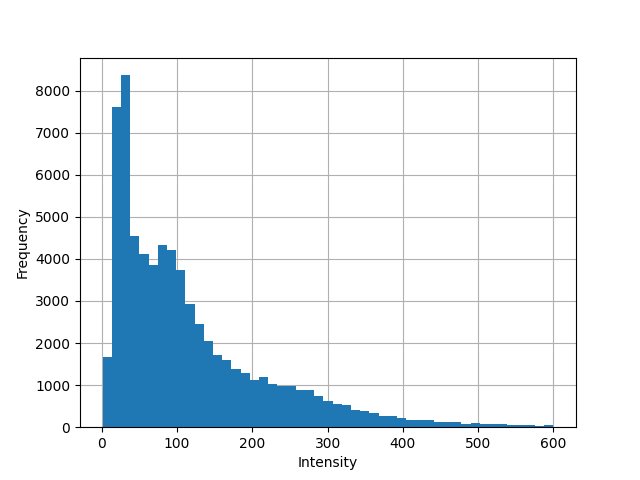

In [72]:
values = sitk.GetArrayViewFromImage(masked_R_breast).flatten()

fig, ax = plt.subplots(1,1)
ax.hist(values, bins=np.linspace(1,600,50), histtype='stepfilled', lw=2)
#ax.set_yscale('log')
ax.grid()
ax.set_axisbelow(True)
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
fig.show()

In [73]:
image_mri=WES_010_6_B50T
arr_mri = sitk.GetArrayFromImage(image_mri)
arr_mri[:,:,arr_mri.shape[2]//2:] = 0
image_mri_masked=sitk.GetImageFromArray(arr_mri)
image_mri_masked.CopyInformation(image_mri)

label_threshold_cc_x_f=estimate_tumour_vol(image_mri_masked, lowerthreshold=405, upperthreshold=5000, hole_size=1)

sitk.WriteImage(label_threshold_cc_x_f,"test_label_threshold_010_6_B50T_hist.nii.gz") #is okay

<IPython.core.display.Javascript object>


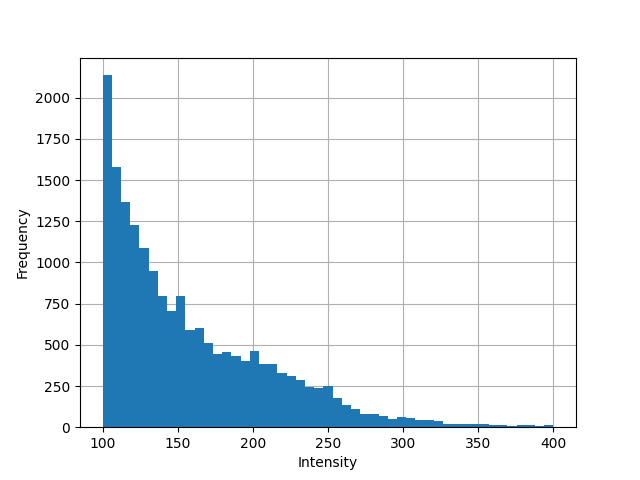

In [79]:
WES_010_6_B800T=sitk.ReadImage("/home/alicja/Documents/WES_010/IMAGES/WES_010_6_20190301_MR_EP2D_DIFF_TRA_SPAIR_ZOOMIT_EZ_B800T_EP2D_DIFF_TRA_SPAIR_ZOOMIT_TRACEW_DFC_5.nii.gz")
WES_010_6_B800T=sitk.Resample(WES_010_6_B800T,WES_010_6_B50T)

masked_R_breast = sitk.Mask(WES_010_6_B800T, breast_contour_dilate)
values = sitk.GetArrayViewFromImage(masked_R_breast).flatten()

fig, ax = plt.subplots(1,1)
ax.hist(values, bins=np.linspace(100,400,50), histtype='stepfilled', lw=2)
#ax.set_yscale('log')
ax.grid()
ax.set_axisbelow(True)
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
fig.show()

In [82]:
image_mri=WES_010_6_B50T
arr_mri = sitk.GetArrayFromImage(image_mri)
arr_mri[:,:,arr_mri.shape[2]//2:] = 0
image_mri_masked=sitk.GetImageFromArray(arr_mri)
image_mri_masked.CopyInformation(image_mri)

label_threshold_cc_x_f=estimate_tumour_vol(image_mri_masked, lowerthreshold=330, upperthreshold=5000, hole_size=1)

sitk.WriteImage(label_threshold_cc_x_f,"test_label_threshold_010_6_B800T_hist.nii.gz")  #okay but no time

<IPython.core.display.Javascript object>


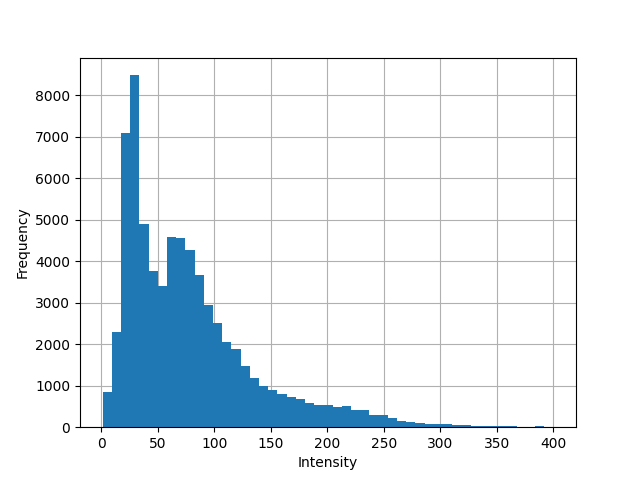

In [105]:
WES_010_6_T2w=sitk.ReadImage("/home/alicja/Documents/WES_010/IMAGES/WES_010_6_20190301_MR_T2_TSE_TRA_SPAIR_TSE2D1_11_T2_TSE_TRA_SPAIR_3.nii.gz")
WES_010_6_T2w=sitk.Resample(WES_010_6_T2w,WES_010_6_B50T)

masked_R_breast = sitk.Mask(WES_010_6_B800T, breast_contour_dilate)
values = sitk.GetArrayViewFromImage(masked_R_breast).flatten()

fig, ax = plt.subplots(1,1)
ax.hist(values, bins=np.linspace(1,400,50), histtype='stepfilled', lw=2)
#ax.set_yscale('log')
ax.grid()
ax.set_axisbelow(True)
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
fig.show()

In [109]:
image_mri=WES_010_6_T2w
arr_mri = sitk.GetArrayFromImage(image_mri)
arr_mri[:,:,arr_mri.shape[2]//2:] = 0
arr_mri[:,:,:177] = 0


image_mri_masked=sitk.GetImageFromArray(arr_mri)
image_mri_masked.CopyInformation(image_mri)
image_mri_masked=sitk.Mask(image_mri_masked, breast_contour_dilate)

label_threshold_cc_x_f=estimate_tumour_vol(image_mri_masked, lowerthreshold=100, upperthreshold=5000, hole_size=1)

sitk.WriteImage(label_threshold_cc_x_f,"test_label_threshold_010_6_T2w_hist.nii.gz")#this one doesnt work

<IPython.core.display.Javascript object>


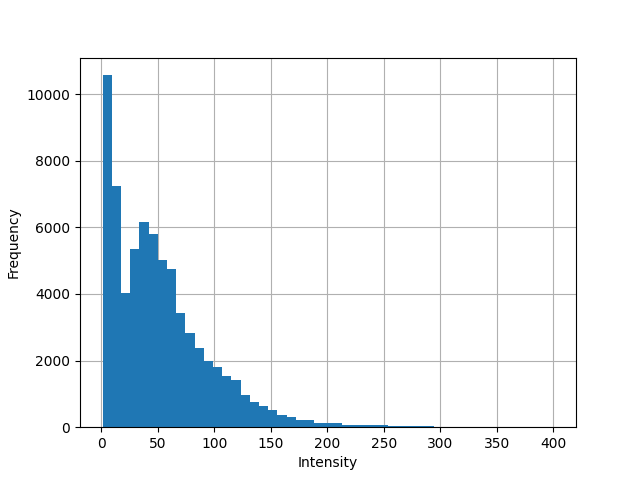

In [111]:
WES_010_6_MPE=sitk.ReadImage("MPE_sub_WES_010_6.nii.gz")
WES_010_6_MPE=sitk.Resample(WES_010_6_MPE,WES_010_6_B50T)

masked_R_breast = sitk.Mask(WES_010_6_MPE, breast_contour_dilate)
values = sitk.GetArrayViewFromImage(masked_R_breast).flatten()

fig, ax = plt.subplots(1,1)
ax.hist(values, bins=np.linspace(1,400,50), histtype='stepfilled', lw=2)
#ax.set_yscale('log')
ax.grid()
ax.set_axisbelow(True)
ax.set_xlabel('Intensity')
ax.set_ylabel('Frequency')
fig.show()

In [123]:
image_mri=WES_010_6_MPE
arr_mri = sitk.GetArrayFromImage(image_mri)
arr_mri[:,:,arr_mri.shape[2]//2:] = 0
arr_mri[:,:,:100] = 0


image_mri_masked=sitk.GetImageFromArray(arr_mri)
image_mri_masked.CopyInformation(image_mri)
image_mri_masked=sitk.Mask(image_mri_masked, breast_contour_dilate)

label_threshold_cc_x_f=estimate_tumour_vol(image_mri_masked, lowerthreshold=85, upperthreshold=5000, hole_size=1)

sitk.WriteImage(label_threshold_cc_x_f,"test_label_threshold_010_6_MPE_hist.nii.gz") #doesnt work

<IPython.core.display.Javascript object>


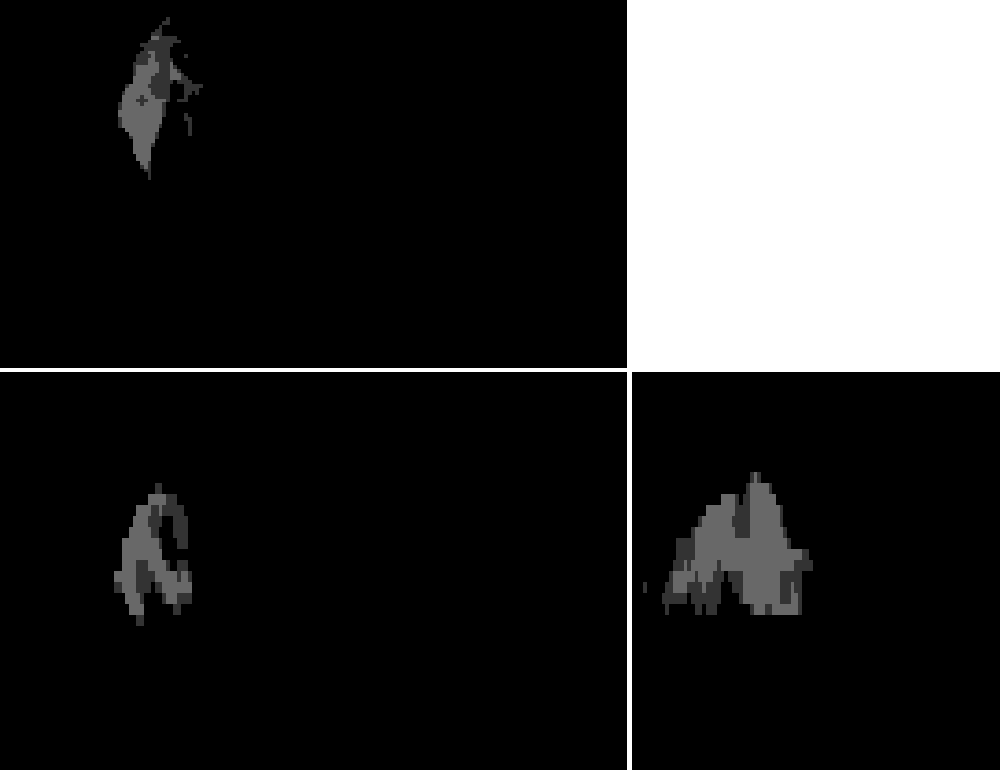

In [126]:
#add segs tp4
seg_B50T=sitk.ReadImage("test_label_threshold_010_6_B50T_hist.nii.gz")
seg_B800T=sitk.ReadImage("test_label_threshold_010_6_B800T_hist.nii.gz")

seg_B800T=sitk.Resample(seg_B800T,seg_B50T)

new_seg_B50T=sitk.LabelMapToBinary(sitk.Cast(seg_B50T, sitk.sitkLabelUInt8))
new_seg_B800T=sitk.LabelMapToBinary(sitk.Cast(seg_B800T, sitk.sitkLabelUInt8))

new_TRACE_seg=(new_seg_B50T+new_seg_B800T)/2#sitk.Cast((new_seg_B50T+new_seg_B800T)/2,sitk.sitkUInt8)
new_seg_1=(sitk.Cast(new_TRACE_seg,sitk.sitkFloat64)) #need to threshold this somehow
vis=ImageVisualiser(new_seg_1, cut=get_com(new_seg_1), window=[0,3])
fig=vis.show()

<IPython.core.display.Javascript object>


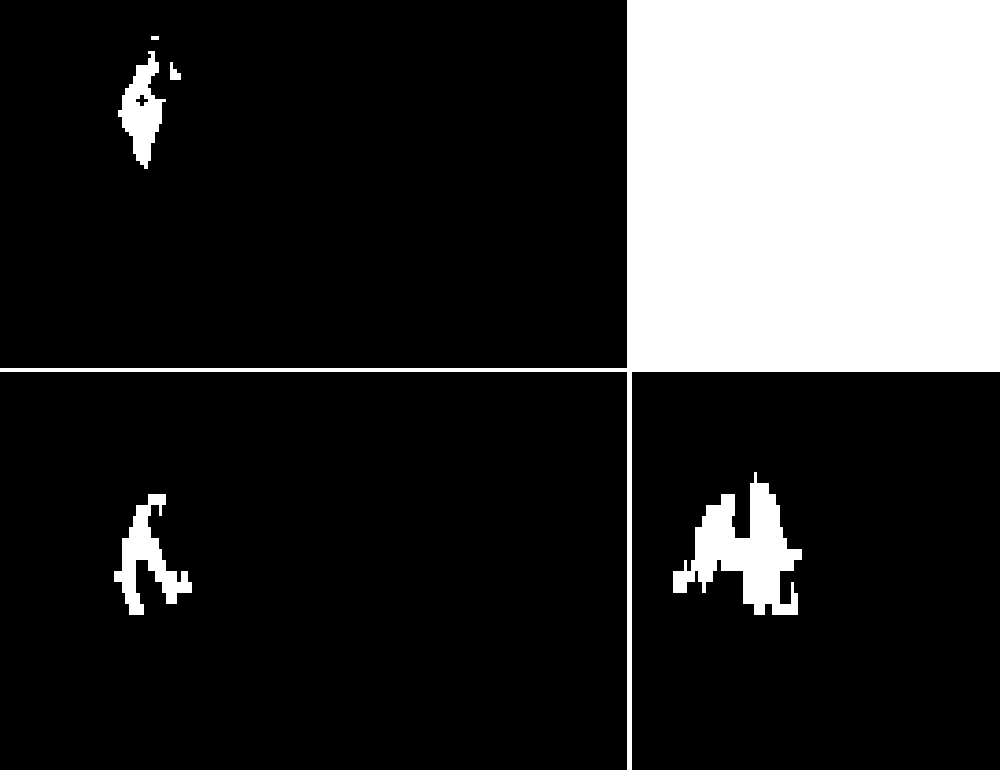

In [127]:
new_seg_1_1=sitk.BinaryThreshold(new_seg_1, lowerThreshold=1)

vis=ImageVisualiser(new_seg_1_1, cut=get_com(new_seg_1), window=[0,1])
fig=vis.show()

In [128]:
sitk.WriteImage(new_seg_1_1,"new_seg_010_6_mri.nii.gz") #very bad

In [130]:
image_mri_masked=sitk.Mask(WES_010_6_MPE,new_seg_1_1)
arr_mri_masked=sitk.GetArrayFromImage(image_mri_masked)
arr_mri_masked[arr_mri_masked<120]=0
tum_MPE=sitk.GetImageFromArray(arr_mri_masked)
tum_MPE.CopyInformation(image_mri_masked)


In [131]:
label_threshold_cc_x_f=estimate_tumour_vol(tum_MPE, lowerthreshold=150, upperthreshold=5000, hole_size=1)
sitk.WriteImage(label_threshold_cc_x_f,"test_label_threshold_010_6_MPE_hist_new.nii.gz") #doesnt work either

In [2]:
#date order: 29/08, 10/10, 01/03 (next year)
#volumes
img1=sitk.ReadImage("new_seg_010_4_mri.nii.gz")
img2=sitk.ReadImage("new_seg_010_5_mri.nii.gz")
img3=sitk.ReadImage("new_seg_010_6_mri.nii.gz")

arr1=sitk.GetArrayFromImage(img1)
arr2=sitk.GetArrayFromImage(img2)
arr3=sitk.GetArrayFromImage(img3)

vol1=np.sum(arr1==1)
vol2=np.sum(arr2==1)
vol3=np.sum(arr3==1)

In [3]:
print(vol1, vol2, vol3)

938 1448 1804
